In [19]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [20]:
import os
import time

start = time.time()
if os.path.isdir("../notebooks/"):
    os.chdir("..")

In [21]:
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from badseeds import seedbank, fig_5

plt.rcParams["font.family"] = "serif"

In [22]:
# path to config json file containing paths to datasets. change if necessary
CONFIG_PATH = "./config.json"

In [23]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

In [24]:
%%memit
# Get our gathered seeds
seeds = seedbank.seedbanking(
    config["seeds"]["dir_path"] + "seeds.json", index=False
)
# And our pairings
pair_df = pd.read_csv(config["pairs"]["dir_path"] + "seed_set_pairings.csv")

peak memory: 798.70 MiB, increment: 1.79 MiB


In [25]:
%%memit
# initialize our dict containing embeddings organized by corpus
corpus_embds = {
    "goodreads_hb": {"0": [], "10": []},
    "goodreads_r": {"0": [], "10": []},
    "wiki": {"0": [], "10": []},
    "nyt": {"0": [], "10": []},
}

peak memory: 798.70 MiB, increment: 0.00 MiB


In [26]:
%%memit
# Can now compute our metrics for each corpus
for i, corpus in enumerate(corpus_embds.keys()):
    for min_freq in [0, 10]:
        print(
            f"Computing metrics for model trained on {corpus} with min_freq={min_freq}..."
        )
        # for more verbose output, set verbose to True
        corpus_embds[corpus][str(min_freq)] = fig_5.comp_fig_5_metrics(
            seeds, pair_df, config, corpus, min_freq, 42, False
        )
    if i == len(corpus_embds.keys()) - 1:
        print("Done.")
    else:
        print("\n")

Computing metrics for model trained on goodreads_hb with min_freq=0...
Computing metrics for model trained on goodreads_hb with min_freq=10...


Computing metrics for model trained on goodreads_r with min_freq=0...
Computing metrics for model trained on goodreads_r with min_freq=10...


Computing metrics for model trained on wiki with min_freq=0...
Computing metrics for model trained on wiki with min_freq=10...


Computing metrics for model trained on nyt with min_freq=0...
Computing metrics for model trained on nyt with min_freq=10...
Done.
peak memory: 3828.85 MiB, increment: 3030.15 MiB


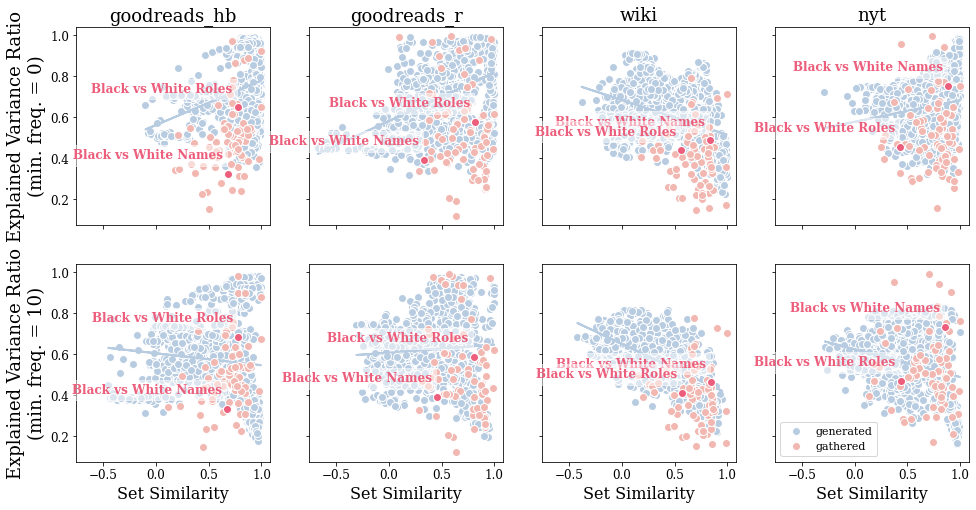

peak memory: 879.52 MiB, increment: 0.12 MiB


In [27]:
%%memit
# and now we plot
fig, (row_0, row_10) = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(16, 8))

for r, (freq, row) in enumerate(zip(["0", "10"], [row_0, row_10])):
    for c, (corpus, ax) in enumerate(zip(corpus_embds.keys(), row)):
        (
            gathered_exp_var,
            generated_exp_var,
            gathered_set_sim,
            generated_set_sim,
        ) = corpus_embds[corpus][freq]

        # additional processing§
        gen_coef = np.polyfit(generated_set_sim, generated_exp_var, 1)
        gen_poly1d_fn = np.poly1d(gen_coef)
        # highlighted seed sets
        names_idx = pair_df[
            pair_df["ID_A"] == "white_names-Knoche_et_al_2019"
        ].index.to_list()[0]
        roles_idx = pair_df[
            pair_df["ID_B"] == "caucasian_roles-Manzini_et_al_2019"
        ].index.to_list()[0]

        # generated
        ax.plot(
            generated_set_sim,
            generated_exp_var,
            "o",
            markersize=8,
            markerfacecolor="#B8CCE1",
            markeredgecolor="white",
            label="generated",
        )
        ax.plot(
            generated_set_sim,
            gen_poly1d_fn(generated_set_sim),
            color="#B8CCE1",
            linewidth=2,
        )
        # gathered
        ax.plot(
            gathered_set_sim,
            gathered_exp_var,
            "o",
            markersize=8,
            markerfacecolor="#F1B7B0",
            markeredgecolor="white",
            label="gathered",
        )

        highlighted_set_sim = [gathered_set_sim[idx] for idx in [names_idx, roles_idx]]
        highlighted_exp_var = [gathered_exp_var[idx] for idx in [names_idx, roles_idx]]
        # highlighted gathered
        ax.plot(
            highlighted_set_sim,
            highlighted_exp_var,
            "o",
            markersize=8,
            markerfacecolor="#EC5E7B",
            markeredgecolor="white",
        )

        for i, label in enumerate(["Black vs White Names", "Black vs White Roles"]):
            ax.annotate(
                label,
                (highlighted_set_sim[i], highlighted_exp_var[i]),
                xytext=(-5, 15),
                textcoords="offset points",
                horizontalalignment="right",
                color="#EC5E7B",
                weight="heavy",
                fontsize=12,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="white"),
            )

        ax.tick_params(axis="both", which="major", labelsize=12)
        if r == 1:
            ax.set_xlabel("Set Similarity", fontsize=16)
            if c == 3:
                ax.legend(loc="lower left", fontsize=11)
        if c == 0:
            ax.set_ylabel(
                f"Explained Variance Ratio\n(min. freq. = {freq})", fontsize=18
            )
        if r == 0:
            ax.set_title(f"{corpus}", fontsize=18)

# fig.tight_layout()
plt.show()

In [28]:
# save to latex
# fig.savefig("images/fig_5.pdf", bbox_inches="tight")

In [29]:
print("Time taken is: ", time.time() - start)

Time taken is:  53.95541739463806
